In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

# customized keras_preprocessing.image in preprocess_image.py
# u_net in the network.py
# mean_iou metric in metrics.py
# predict_mask in utils.py

from lib import *

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
import sys
import random

In [4]:
import warnings
# block tensorflow~numpy warnings
warnings.filterwarnings('ignore')

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Environment

In [5]:
BATCH_SIZE = 10 
# memory issues on 8 gig memory container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)


# Данные

Посмотрим на данные:

In [6]:
# get_xy reshapes the images to 240 * 240 

X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [7]:
random_index = np.random.choice(X_train.shape[0])

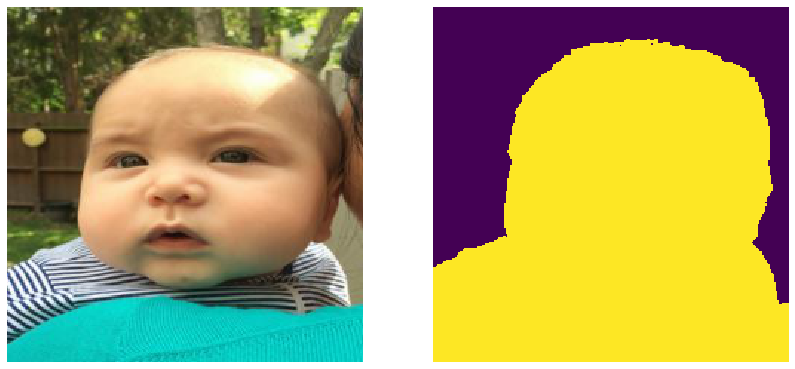

In [8]:
show_img_with_mask(X_train[random_index], Y_train[random_index][:,:,0])

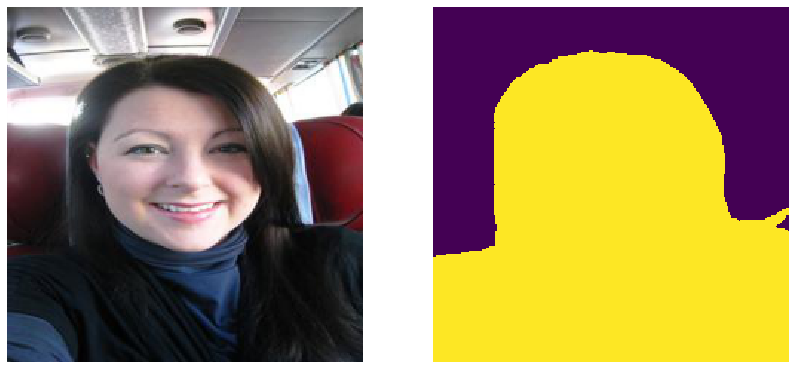

In [9]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_validate[random_index], Y_validate[random_index][:,:,0])

# Preprocessing

## data augmentation

In [20]:
# apply shear, rotation, zoom, shift, fillcontrast and contrast_stretching to augment train

image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)



In [18]:
# augment valiadation images 
image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_validate, augment=True, seed=seed)
mask_datagen.fit(Y_validate, augment=True, seed=seed)

x_val=image_datagen.flow(X_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen.flow(Y_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

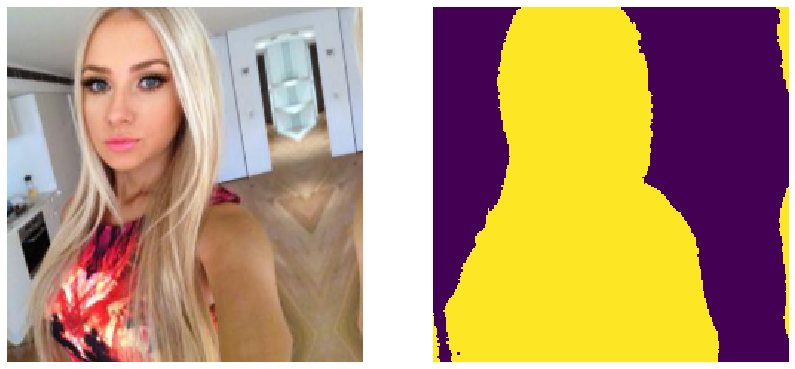

In [21]:
show_img_with_mask(x.next()[0].astype(np.uint8), np.squeeze(y.next()[0].astype(np.uint8)))

In [22]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

## compile u-net

In [24]:
model = u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensor("conv2d_19_target:0", shape=(?, ?, ?, ?), dtype=float32)
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 240, 3)  0           input_1[0][0]                    
________________________________________________________________________________

## train u-net

In [25]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation-3.1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1522s 6s/step - loss: 0.6021 - mean_iou: 0.3367 - val_loss: 0.6388 - val_mean_iou: 0.3865

Epoch 00001: val_loss improved from inf to 0.63885, saving model to model-segmentation-3.1.h5
Epoch 2/15
250/250 [==============================] - 1365s 5s/step - loss: 0.5392 - mean_iou: 0.4046 - val_loss: 0.5625 - val_mean_iou: 0.4209

Epoch 00002: val_loss improved from 0.63885 to 0.56247, saving model to model-segmentation-3.1.h5
Epoch 3/15
250/250 [==============================] - 1451s 6s/step - loss: 0.5068 - mean_iou: 0.4337 - val_loss: 0.4905 - val_mean_iou: 0.4441

Epoch 00003: val_loss improved from 0.56247 to 0.49054, saving model to model-segmentation-3.1.h5
Epoch 4/15
250/250 [==============================] - 1323s 5s/step - loss: 0.4755 - mean_iou: 0.4533 - val_loss: 0.4602 - val_mean_iou: 0.4621

Epoch 00004: val_loss improved from 0.49054 to 0.46022, saving model to model-segmentation-3.1.h5
Epoch 5/15
250/250 [============

In [26]:
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[earlystopper, checkpointer])

Epoch 1/5
250/250 [==============================] - 1441s 6s/step - loss: 0.3125 - mean_iou: 0.5824 - val_loss: 1.0138 - val_mean_iou: 0.5861

Epoch 00001: val_loss improved from inf to 1.01384, saving model to model-segmentation-3.2.h5
Epoch 2/5
250/250 [==============================] - 1527s 6s/step - loss: 0.2734 - mean_iou: 0.5897 - val_loss: 0.3419 - val_mean_iou: 0.5933

Epoch 00002: val_loss improved from 1.01384 to 0.34191, saving model to model-segmentation-3.2.h5
Epoch 3/5
250/250 [==============================] - 1479s 6s/step - loss: 0.2609 - mean_iou: 0.5970 - val_loss: 0.2277 - val_mean_iou: 0.6008

Epoch 00003: val_loss improved from 0.34191 to 0.22774, saving model to model-segmentation-3.2.h5
Epoch 4/5
250/250 [==============================] - 1656s 7s/step - loss: 0.2531 - mean_iou: 0.6044 - val_loss: 0.2857 - val_mean_iou: 0.6078

Epoch 00004: val_loss did not improve from 0.22774
Epoch 5/5
250/250 [==============================] - 1463s 6s/step - loss: 0.2373 -

In [ ]:
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1523s 6s/step - loss: 0.2902 - mean_iou: 0.6163 - val_loss: 1.2186 - val_mean_iou: 0.6189

Epoch 00001: val_loss improved from inf to 1.21863, saving model to model-segmentation-3.2.h5
Epoch 2/15
250/250 [==============================] - 1430s 6s/step - loss: 0.2399 - mean_iou: 0.6218 - val_loss: 0.3235 - val_mean_iou: 0.6247

Epoch 00002: val_loss improved from 1.21863 to 0.32352, saving model to model-segmentation-3.2.h5
Epoch 3/15
250/250 [==============================] - 1509s 6s/step - loss: 0.2292 - mean_iou: 0.6276 - val_loss: 0.2282 - val_mean_iou: 0.6305

Epoch 00003: val_loss improved from 0.32352 to 0.22817, saving model to model-segmentation-3.2.h5
Epoch 4/15
250/250 [==============================] - 1475s 6s/step - loss: 0.2255 - mean_iou: 0.6333 - val_loss: 0.2389 - val_mean_iou: 0.6359

Epoch 00004: val_loss did not improve from 0.22817
Epoch 5/15
 87/250 [=========>....................] - ETA: 15:04 - loss: 0.2174